In [55]:
#imports needed for the project 

import librosa #used to anazlyze audio file
from scipy.io import wavfile
import librosa.display
import soundfile
import os, glob
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/axes/_axes.py:7628: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


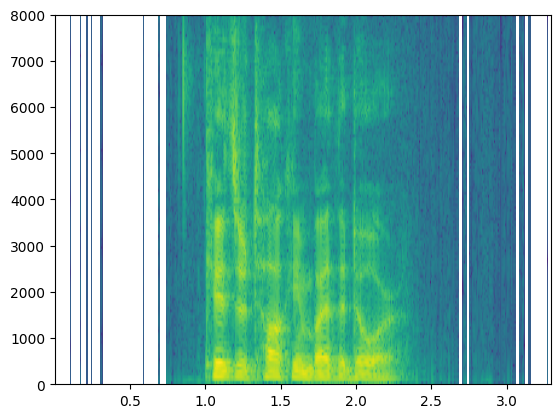

In [57]:
#testing the audio to make to show any errors with the audio 
Fs, aud = wavfile.read('/Users/desjahthompson/Desktop/Data science project/dataset/Actor_01/03-01-01-01-01-01-01.wav')
first = aud[:int(Fs*125)]
powerSpectrum, frequenciesFound, time, imageAxis = plt.specgram(first, Fs=Fs)
plt.show()

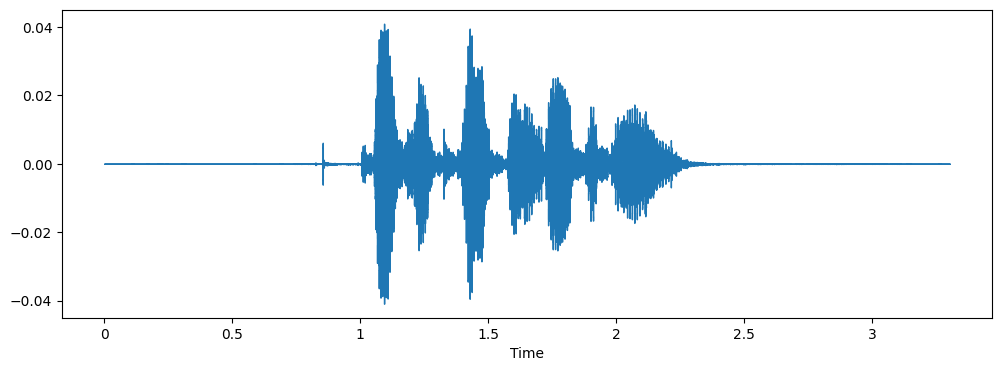

In [58]:
# showing the waveform
# this is where you can help determine the time of the audio to pick certain words to express certain emotion when tranferred into text

data, sampling_rate = librosa.load('/Users/desjahthompson/Desktop/Data science project/dataset/Actor_01/03-01-01-01-01-01-01.wav')

plt.figure(figsize=(12, 4))
librosa.display.waveshow(data, sr=sampling_rate)
plt.show()

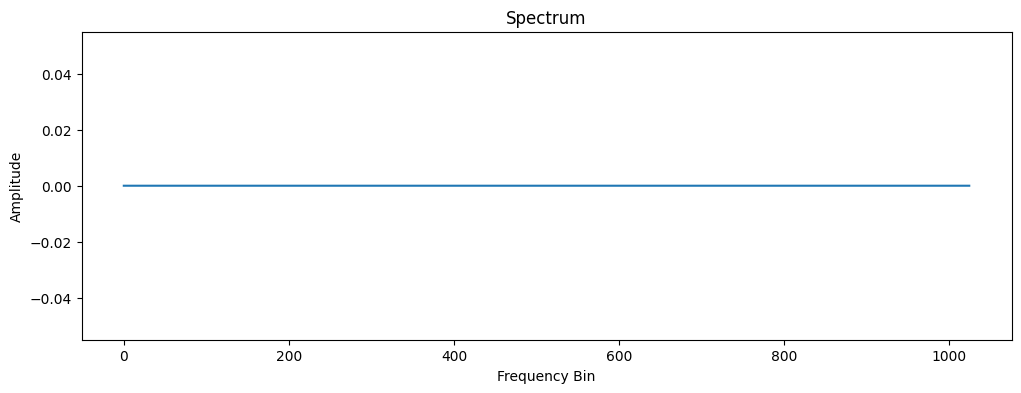

In [59]:
#shows the frequency of the audio showing that the audios are mono

n_fft = 2048
plt.figure(figsize=(12, 4))
ft = np.abs(librosa.stft(data[:n_fft], hop_length = n_fft+1))
plt.plot(ft);
plt.title('Spectrum');
plt.xlabel('Frequency Bin');
plt.ylabel('Amplitude');

/var/folders/hw/f5pqd8y963l13t9x4rr6y2z80000gn/T/ipykernel_82114/2611314785.py:2: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mfccs = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=13) #computed MFCCs over frames.


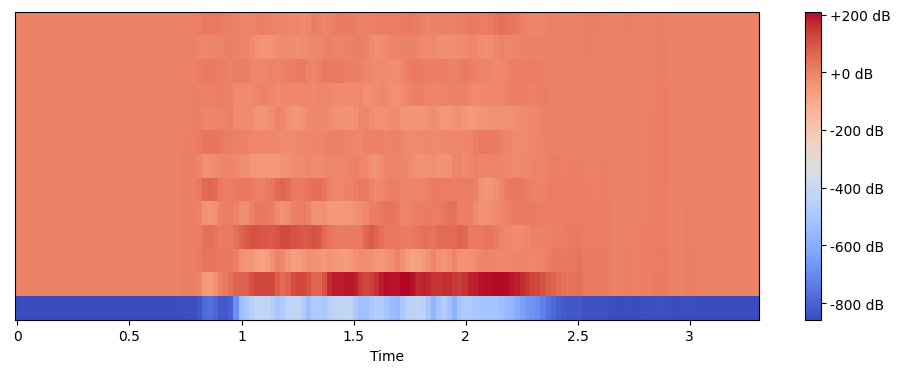

In [60]:
# This shows a visual of the mfccs for the audio files in which shows the overall shape of the spectral envelope

plt.figure(figsize=(12, 4))
mfccs = librosa.feature.mfcc(data, sr=sampling_rate, n_mfcc=13) #computed MFCCs over frames.
librosa.display.specshow(mfccs, sr=sampling_rate, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.show()

In [3]:
# Extract features mfcc, chroma, mel from a sound file
# function to run all at once 
# also used to get the train splits for the confusion matrix 

def extract_feature(file_name, mfcc, chroma, mel):
    with soundfile.SoundFile(file_name) as sound_file:
        X = sound_file.read(dtype="float32")
        sample_rate=sound_file.samplerate
        if chroma:
            stft=np.abs(librosa.stft(X))
        result=np.array([])
        if mfcc:
            mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
            result=np.hstack((result, mfccs))
        if chroma:
            chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
            result=np.hstack((result, chroma))
        if mel:
            mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
            result=np.hstack((result, mel))
    return result

In [4]:
# sparating the dataset by the emotion using numbers

emotions={
  '01':'neutral',
  '02':'calm',
  '03':'happy',
  '04':'sad',
  '05':'angry',
  '06':'fearful',
  '07':'disgust',
  '08':'surprised'
}

#Emotions to observed
observed_emotions=['calm', 'happy', 'fearful', 'disgust']

In [33]:
# path: /Users/desjahthompson/Desktop/Data science project/AudioData/Actor_*\\*.wav

#Load the data and extract features for each sound file
#x is used to hold the list and y is used to hold the feautures

def load_data(test_size=0.2):
    x,y=[],[]
    for file in glob.glob("/Users/desjahthompson/Desktop/Data science project/dataset/Actor_*/*.wav"):
        file_name=os.path.basename(file)
        emotion=emotions[file_name.split("-")[2]]
        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        y.append(emotion)
    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)

In [35]:
# Split the dataset
x_train, x_test, y_train, y_test= load_data(test_size=0.25)

# Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

/var/folders/hw/f5pqd8y963l13t9x4rr6y2z80000gn/T/ipykernel_82114/4137481150.py:17: FutureWarning: Pass y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
/var/folders/hw/f5pqd8y963l13t9x4rr6y2z80000gn/T/ipykernel_82114/4137481150.py:17: FutureWarning: Pass y=[ 3.0517578e-05  0.0000000e+00  0.0000000e+00 ...  0.0000000e+00
 -3.0517578e-05 -3.0517578e-05] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
/var/folders/hw/f5pqd8y963l13t9x4rr6y2z80000gn/T/ipykernel_82114/4137481150.py:17: FutureWarning: Pass y=[ 0.0000000e+00  0.0000000e+00  0.0000000e+00 ... -3.0517578e-05
  0.0000000e+00  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel=np.mean(librosa.featur

(576, 192)


In [38]:
#Initialize the Multi Layer Perceptron Classifier

model=MLPClassifier(alpha=0.01, batch_size=256, epsilon=1e-08, hidden_layer_sizes=(300,), learning_rate='adaptive', max_iter=500)

# Train the model
model.fit(x_train,y_train)

MLPClassifier(alpha=0.01, batch_size=256, hidden_layer_sizes=(300,),
              learning_rate='adaptive', max_iter=500)

In [40]:
#Predict for the test set
y_pred=model.predict(x_test)

In [39]:
#Calculate the accuracy of our model
accuracy=accuracy_score(y_true=y_test, y_pred=y_pred)

#Print the accuracy
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 75.00%


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Confusion matrix, without normalization
[[34  6  6  1]
 [10 34  6  5]
 [ 2  8 22  6]
 [ 4  6 12 30]]


<function matplotlib.pyplot.show(close=None, block=None)>

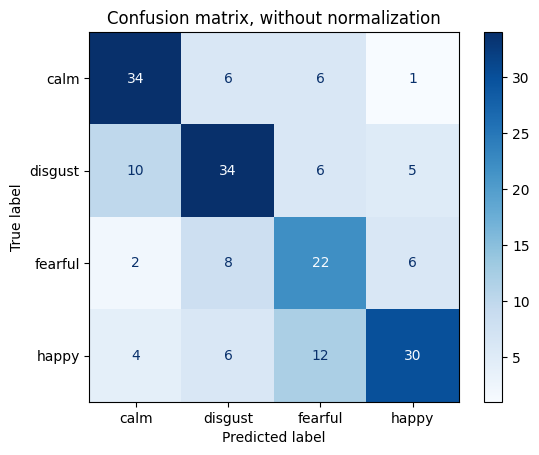

In [54]:

#Use the confusion Matrix to double check the actual errors in the classifier 

svc = svm.SVC(kernel='linear',C=1, gamma='auto').fit(x_train,y_train)

title_option = [("Confusion matrix, without normalization", None)]

for title, normalize in title_option:

    disp =plot_confusion_matrix(svc,x_test,y_test,cmap=plt.cm.Blues, normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
plt.show